In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from cross_system_integration.model._xxjointmodel import XXJointModel


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /net/vast-storage/scratch/vast/kellislab/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0


In [2]:
adata=sc.read('/om2/user/khrovati/data/cross_system_integration/test_data/pancreas_3species_15000.h5ad')


In [3]:
# Setup adata
adata = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    categorical_covariate_keys=['batch'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [4]:
# Initialise the model
model = XXJointModel(
    adata=adata,
    prior='vamp', 
    n_prior_components=5,
    encode_pseudoinputs_on_eval_mode=True,
    z_dist_metric = 'MSE_standard',
)
# Train
max_epochs=200
model.train(
    max_epochs=max_epochs,
    # Parameters used for checking losses
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0, 
    # Loss weights
    plan_kwargs={
        'loss_weights':{
           'kl_weight':1.0,
           'reconstruction_weight':1.0,
           'z_distance_cycle_weight':2.0,

   }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [08:00<00:00,  2.40s/it, loss=-686, v_num=1]


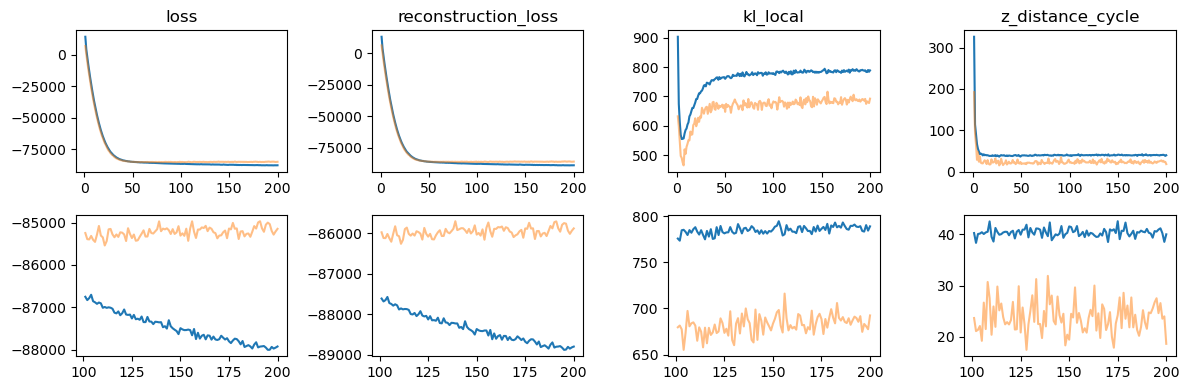

In [5]:
# Plot loses

# Make detailed plot after N epochs
epochs_detail_plot=100
steps_detail_plot = epochs_detail_plot*int(
    model.trainer.logger.history['loss_validation'].shape[0]/max_epochs)
detail_plot=epochs_detail_plot

# Loss plotting adapted to the above specified model and its training

# Losses to plot
# Set to plot only loses which we specified to be used for training above
losses=[
     'loss_train',
     'reconstruction_loss_train',
     'kl_local_train',
     'z_distance_cycle_train']
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for val leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently this works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,epochs_detail_plot),
        (l_val_values,'tab:orange',0.5, detail_plot)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

In [6]:
# Get embedidng - save it into X of new adata
embed= model.embed(adata=adata)
embed=sc.AnnData(embed,obs=adata.obs)
# Make system categorical for plotting below
embed.obs['system']=embed.obs['system'].map({0:'mouse',1:'human',2:'pig'})


In [7]:
# UMAP
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


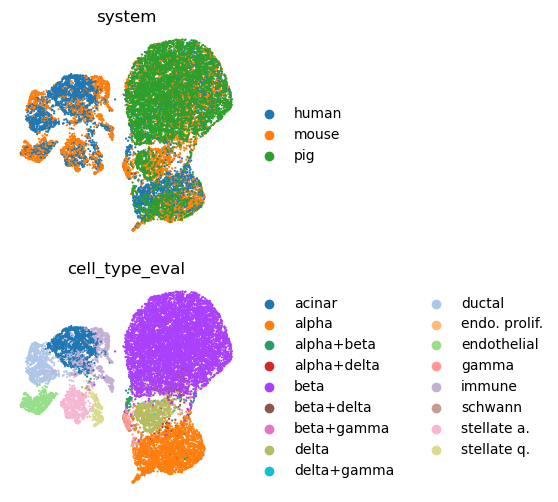

In [8]:
# Plot embedding UMAP
cols=['system','cell_type_eval']
fig,axs=plt.subplots(len(cols),1,figsize=(3,3*len(cols)))
for col,ax in zip(cols,axs):
    sc.pl.embedding(embed,'X_umap',color=col,s=10,ax=ax,show=False,sort_order=False,frameon=False)



/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWa

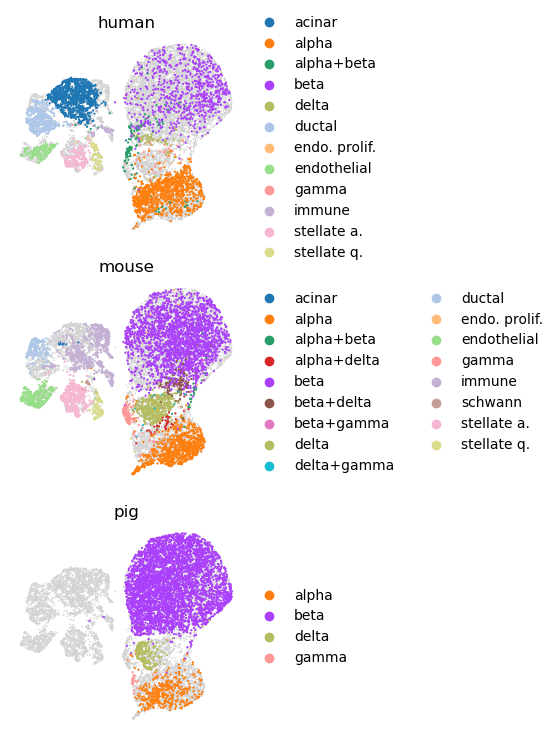

In [13]:
# Plot cts per system
systems=sorted(embed.obs.system.unique())
ncols=len(systems)
fig,axs=plt.subplots(ncols,1,figsize=(3,3*ncols))
for i,system in enumerate(systems):
    ax=axs[i]
    sc.pl.umap(embed, ax=ax,show=False,s=5,frameon=False)
    sc.pl.umap(embed[embed.obs.system==system,:],color='cell_type_eval',
               ax=ax,show=False,s=10,frameon=False,title=system)






C: Seems that it kind of works, although there are some issues with immune&acinar. Maybe to do with low number of used genes or too high cycle weight etc 